In [1]:
import os
from pathlib import Path
os.chdir(Path().cwd().parent)

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))
sns.set_context(sns.plotting_context('notebook', font_scale=1.3))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Objectives


Research questions
----------
1. Which features strongly correlate with the critical temperature required to attain superconductivity?
2. Presence of which elements in the compound generally tends to give the highest critical temperatures for superconductivity?
3. What is the most accurate (or least erroneous) model we can build to predict the critical temperature required for superconductivity for a given compound?


In [3]:
raw = pd.read_csv('dataset/train.csv')
rawelem = pd.read_csv('dataset/unique_m.csv')

In [4]:
raw.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [5]:
rawelem.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


## **Q1** | Which features are the strongest indicators of critical temperature?

In [6]:
temp = raw['critical_temp']
features = raw.drop(columns=['critical_temp']).columns.tolist()
correlations = {feature: [temp.corr(raw[feature])] for feature in features}

In [7]:
corrdf = (
    pd.DataFrame(correlations, index=['Correlations'])
    .T
    .sort_values(by='Correlations', 
                 key=lambda x: x.abs(), 
                 ascending=False)
    .reset_index()
    .rename(columns={'index': 'Features'})
)

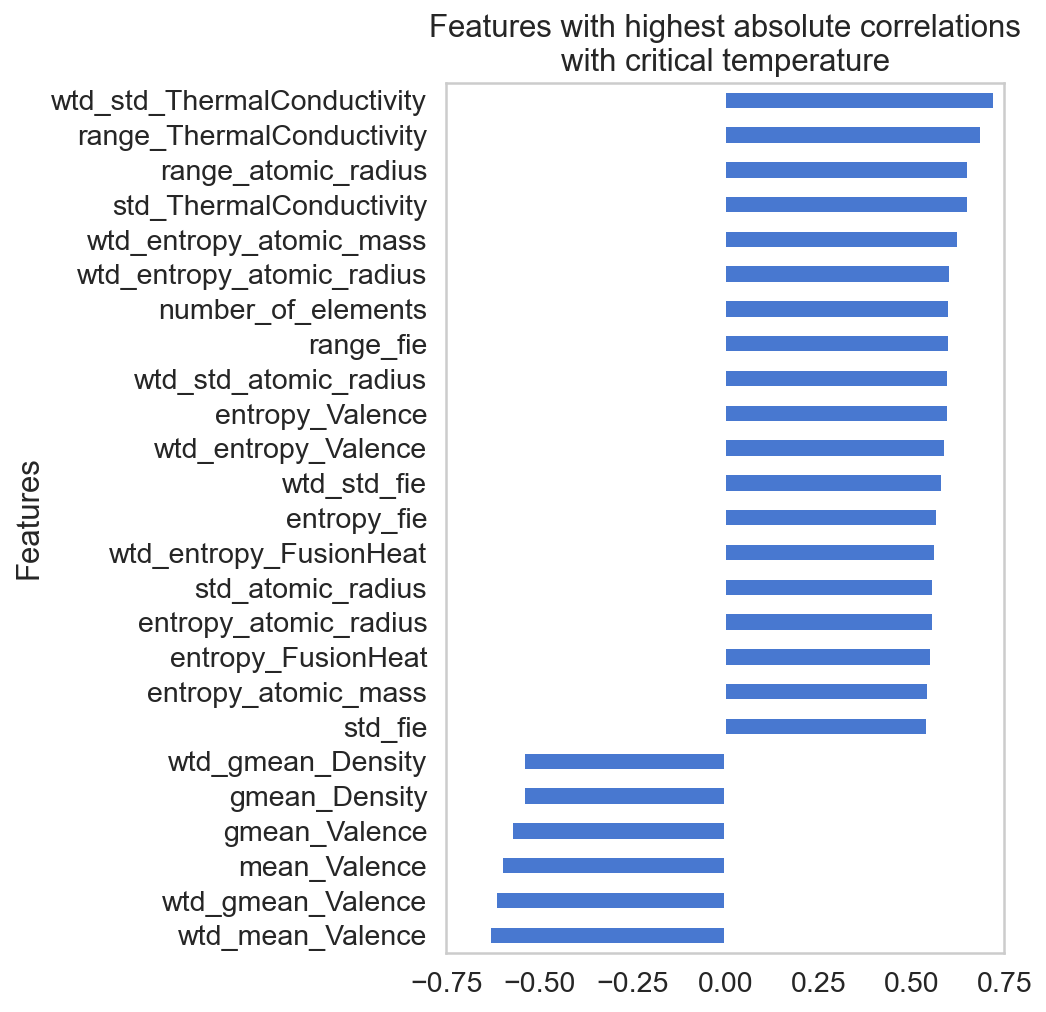

In [164]:
ax = (
    corrdf
    .loc[lambda x: x['Correlations'].abs() >= 0.5]
    .sort_values(by='Correlations')
    .plot(x='Features', 
          y='Correlations',
          figsize=(5, 8),
          kind='barh', 
          legend=False,
          xlim=(-0.75, 0.75),
          title='Features with highest absolute correlations\nwith critical temperature')
)
ax.grid(False)

## **Q2** | Presence of which elements generally tends to give the highest critical temperatures?

In [29]:
rawelem.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [48]:
element_cols = rawelem.drop(columns=['critical_temp', 'material']).columns.tolist()

presence = (
    rawelem
    .melt(id_vars=['critical_temp', 'material'], var_name='element', value_name='present')
    .assign(present = lambda x: x['present'].astype(bool))
    .loc[lambda x: x['present']]
    .drop(columns=['material', 'present'])
)

In [152]:
presence_info = (
    presence
    .groupby(by='element')
    .agg({
        'critical_temp': ['mean', 'median', 'std', 'min', 'max', 'count']
    })
    .sort_values(by=('critical_temp', 'median'), ascending=False)
)

In [157]:
presence_info.tail(10)

critical_temp                                        
                 mean median        std      min    max count
element                                                      
Ag          27.494627  3.610  42.605843  0.00650  126.9   156
Pt           6.811970  3.200   9.358230  0.00062   81.0   419
Sb          14.767458  3.000  32.285270  0.01900  136.0   343
Rh           4.379652  2.940   4.444798  0.00021   36.3   643
Te           5.844849  2.800  11.125707  0.01200  120.6   527
Pd           3.738456  2.600   4.272164  0.03200   51.6   487
Ir           3.680543  2.445   4.719339  0.01670   38.0   572
In           6.551950  2.400  15.373923  0.00050   95.5   544
Au           9.966998  2.300  24.125974  0.00050  133.0   242
Os           2.957413  1.830   2.805492  0.01670   12.7   255

In [84]:
high_temp_elements = presence_info.head(10).index.tolist()

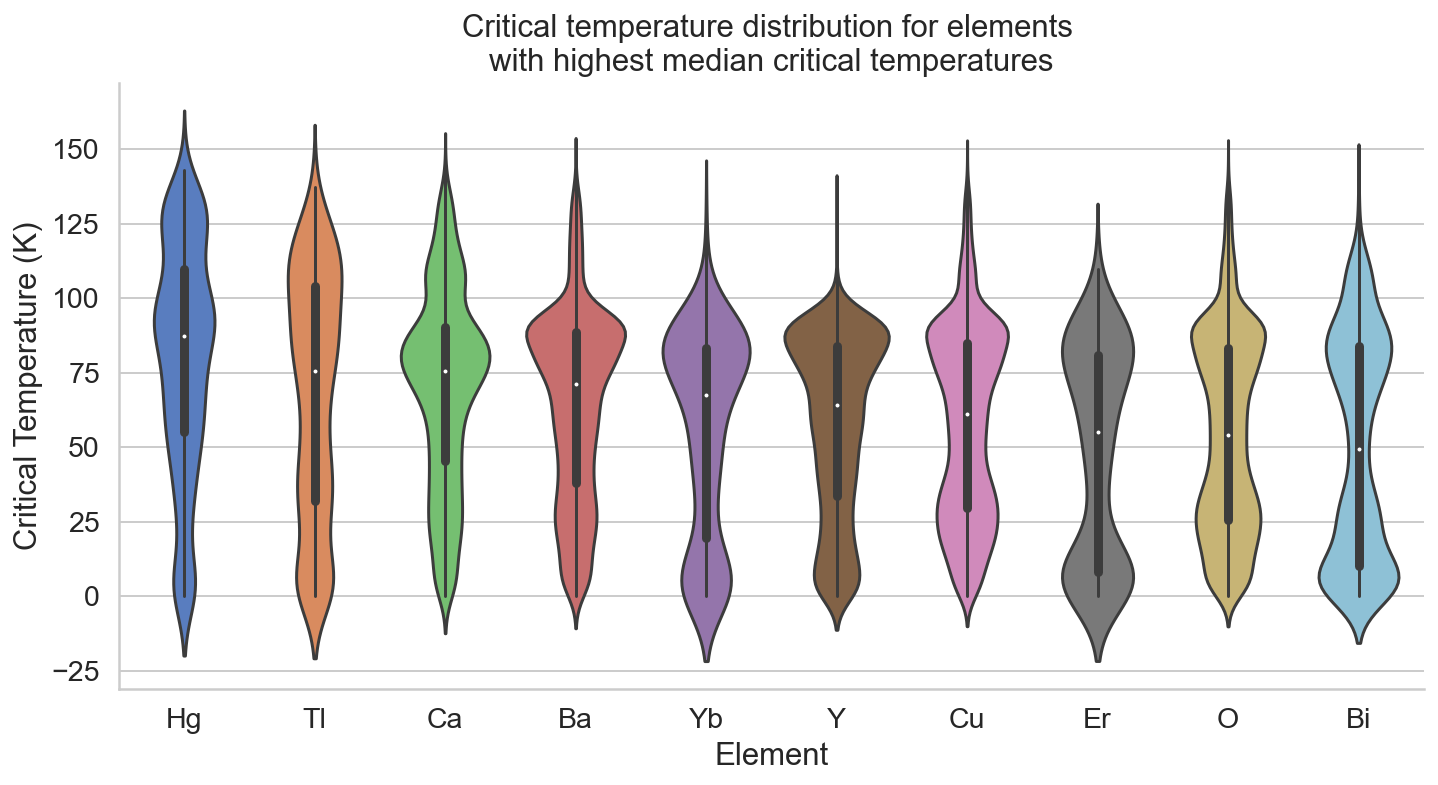

In [175]:
g = sns.catplot(
    x='element', 
    y='critical_temp', 
    data=presence[presence['element'].isin(high_temp_elements)], 
    kind='violin',
    aspect=2,
    order=high_temp_elements,
    palette=sns.color_palette('muted')
)

g.ax.set_xlabel('Element')
g.ax.set_ylabel('Critical Temperature (K)')
_ = g.ax.set_title('Critical temperature distribution for elements \nwith highest median critical temperatures')

## **Q3** | What is the most accurate (or least erroneous) model we can build to predict the critical temperature?

In [176]:
raw.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [199]:
X = raw[features]
y = raw['critical_temp']

X = StandardScaler().fit_transform(X)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [201]:
print(X_train.shape)
print(X_test.shape)

(15947, 81)
(5316, 81)


In [286]:
model_types = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR()
}

grid_search_params = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [7, 11, 15, 19]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 50],
        'kernel': ['linear', 'rbf']
    }
}

In [287]:
def get_parameter_description(params):
    s = ''
    for param, value in params.items():
        s += f'{param}: {value} | '
    return s[:-3]

In [288]:
%%time

result_fields = {
    'model_type',
    'parameters',
    'rmse'
}

best_models = {}

result_dict = {field: [] for field in result_fields}

for model_type in model_types:
    params = grid_search_params[model_type]
    gs_model = GridSearchCV(model_types[model_type], params, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
    gs_model.fit(X_train, y_train)
    
    model_results = gs_model.cv_results_
    result_dict['model_type'].extend([model_type] * len(model_results['mean_test_score']))
    result_dict['parameters'].extend([get_parameter_description(x) for x in model_results['params']])
    result_dict['rmse'].extend(model_results['mean_test_score'])
    
    best_models[model_type] = gs_model.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.1min finished


CPU times: user 3min 46s, sys: 857 ms, total: 3min 47s
Wall time: 28min 20s


In [289]:
results = (
    pd.DataFrame(result_dict)
    .assign(rmse = lambda x: -1 * x['rmse'])
    [['model_type', 'parameters', 'rmse']]
)

In [290]:
results

,model_type,parameters,rmse
0,Linear Regression,,17.513823
1,Random Forest,max_depth: 3 | n_estimators: 50,18.246150
2,Random Forest,max_depth: 3 | n_estimators: 100,18.278567
3,Random Forest,max_depth: 3 | n_estimators: 200,18.236868
4,Random Forest,max_depth: 3 | n_estimators: 400,18.256506
5,Random Forest,max_depth: 7 | n_estimators: 50,13.124718
6,Random Forest,max_depth: 7 | n_estimators: 100,13.125411
7,Random Forest,max_depth: 7 | n_estimators: 200,13.106158
8,Random Forest,max_depth: 7 | n_estimators: 400,13.084433
9,Random Forest,max_depth: 11 | n_estimators: 50,10.582349


In [291]:
results.to_csv('results.csv', index=False)